### Objective
-	To plot two types of curves (False Positive Rate/True Positive Rate vs. Threshold and the ROC curve) and compare it for three types of logistic regression models.
-	To obtain the AUC Score for the logistic regression model




In [103]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plt

##### 1. Load the dataset that was cleaned (from the data directory) and see if it requires any more cleaning after reading it (hint: Check the first column). Feed the train data into a Logistic Regression model with an arbitrary random state. 
* Feel free to play around with the parameters of the LogisticRegression class.
* Make sure you have these two numpy arrays ready for the next few parts: prediction probabilities for X_test and the labels of y_test in 1s and 0s, not “Yes” and “No”.


In [3]:
# Read cleaned data training, test, labels
X_train = pd.read_pickle("X_train.pkl")
X_test  = pd.read_pickle("X_test.pkl")
y_train = pd.read_pickle("y_train.pkl")
y_test  = pd.read_pickle("y_test.pkl")

In [5]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.524941,0.517958,0.001198,0.143713,0.586207,0.466667,0.40,0.651163,0.65,0.55,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.726841,0.646503,0.011978,0.179641,0.434483,0.360000,0.14,0.441860,0.71,0.59,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.425178,0.775047,0.000000,0.341317,0.848276,0.333333,0.30,0.255814,0.06,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.681710,0.659735,0.000000,0.263473,0.765517,0.413333,0.44,0.441860,0.59,0.53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.593824,0.642722,0.000000,0.143713,0.586207,0.440000,0.00,0.162791,0.72,0.53,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y_train[0:10]

110803    0
87289     0
134949    0
85553     0
16110     1
57943     1
125834    0
130086    0
124849    0
42945     0
Name: RainTomorrow, dtype: int8

In [18]:
# Create Logistic Regression - Rain Prediction
log_regression = LogisticRegression(solver='liblinear', random_state=0)

In [19]:
# Train the model
log_regression.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

##### 2. A function needs to be written which will compute the False Positive Rates (FPR) and the True Positive Rates (TPR) for several threshold values between 0 and 1 given 2 arguments, the probability values of the labels of X_test and the y_test values in terms of 1s and 0s. Within the function:
* Create a threshold numpy array that has uniformly divided threshold values between 0 and 1 (around a 101 values including 0 and 1).
* For each of these threshold values, calculate the True Positives, True Negatives, False Positives and False Negatives.
* Get the dataframe consisting of each of the four values for all the threshold values. 
* Compute the FPR and TPR for all these threshold values.
* Return this dataframe.
* We will now be using this function for 2 different kinds of plots for 3 different models.

In [68]:
def compute_fpr_tpr(y_rain_prediction, y_test):
    """Computer False Positive Rates and True Positive Rates"""
    threshold_array = np.array([index/100 for index in range(0,101)])
    # Shape to feed into binarize
    y_rain_prediction = y_rain_prediction.reshape(-1,1)
    # hold results of each threshold calculation
    results = []
    for new_threshold in threshold_array:                
        y_new_rain_prediction = binarize(y_rain_prediction,threshold=new_threshold)
        new_confusion_m = confusion_matrix(y_test,y_new_rain_prediction)    
        # Obtain tp, fp, fn, tp
        TN, FP, FN, TP = new_confusion_m.ravel()
        FPR = FP/(FP+TN)
        TPR = TP/(TP+FN)
        # Build list of dicts to construct dataframe
        results.append({'THRESHOLD':new_threshold,'TP':TP,'TN':TN,'FP':FP,'FN':FN,'FPR':FPR,'TPR':TPR})

    return pd.DataFrame(data=results)

In [69]:
# Calculate thresholds
y_rain_prediction = log_regression.predict_proba(X_test)[:,1] 
df_thresholds = compute_fpr_tpr(y_rain_prediction, y_test)

In [70]:
# Display 5 calculated thresholds
df_thresholds.sample(5)

,THRESHOLD,TP,TN,FP,FN,FPR,TPR
1,0.01,6359,2007,20060,13,0.909050,0.997960
51,0.51,2876,21220,847,3496,0.038383,0.451350
85,0.85,872,21999,68,5500,0.003082,0.136849
99,0.99,23,22067,0,6349,0.000000,0.003610
66,0.66,2015,21725,342,4357,0.015498,0.316227


##### 3.	Let the first model be our fitted logistic regression model. Use the function to obtain all the TPR and FPR by passing the predicted probabilities and the y_test values into the function. 
* Plot TPR/FPR (y-axis) vs. threshold values (x-axis). 
* Plot TPR (y-axis) vs. FPR (x-axis). The second plot is known as the ROC curve.


In [72]:
# Calculate thresholds
y_rain_prediction = log_regression.predict_proba(X_test)[:,1] 
df_thresholds = compute_fpr_tpr(y_rain_prediction, y_test)

In [73]:
df_thresholds.shape

(101, 7)

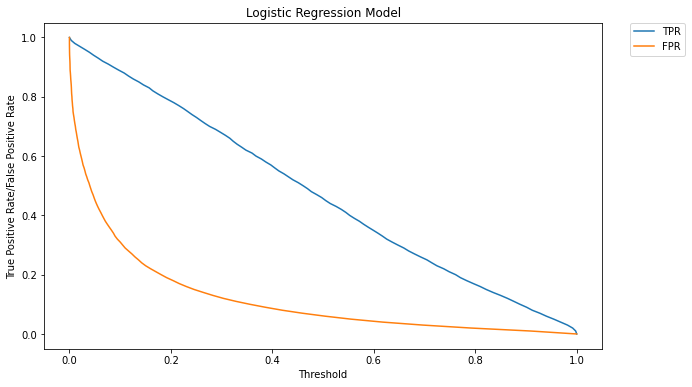

In [74]:
plt.figure(figsize=(10,6))
plt.title('Logistic Regression Model')
plt.xlabel('Threshold')
plt.ylabel('True Positive Rate/False Positive Rate')
plt.plot(df_thresholds['TPR'], df_thresholds['THRESHOLD'], label="TPR")
plt.plot(df_thresholds['FPR'], df_thresholds['THRESHOLD'], label="FPR")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

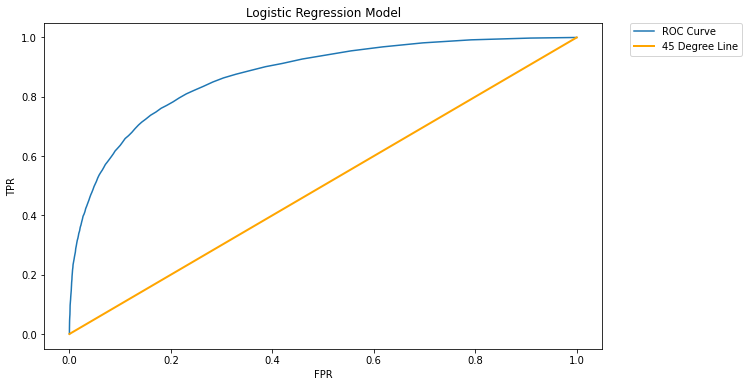

In [75]:
# ROC Curve
plt.figure(figsize=(10,6))
plt.title('Logistic Regression Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot( df_thresholds['FPR'], df_thresholds['TPR'], label="ROC Curve")
# Add 45 degree line
plt.plot([0, 1], [0, 1], color = 'orange', linewidth = 2,  label="45 Degree Line")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

##### 4.	The second model is going to be a radom model, with the predicted values being uniformly distributed between 0 and 1. Create this random numpy array and pass these predicted values (and y_test values) into the function.
* Plot TPR/FPR (y-axis) vs. threshold values (x-axis). 
* Plot TPR (y-axis) vs. FPR (x-axis). The second plot is known as the ROC curve.


In [81]:
# Create random array
y_rain_random = np.random.rand(28439)
df_thresholds = compute_fpr_tpr(y_rain_random, y_test)

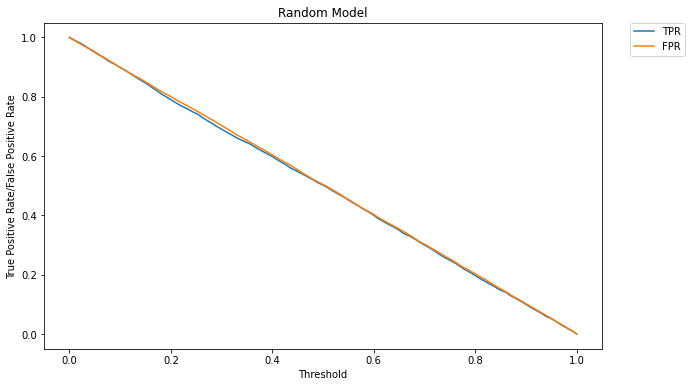

In [82]:
plt.figure(figsize=(10,6))
plt.title('Random Model')
plt.xlabel('Threshold')
plt.ylabel('True Positive Rate/False Positive Rate')
plt.plot(df_thresholds['TPR'], df_thresholds['THRESHOLD'], label="TPR")
plt.plot(df_thresholds['FPR'], df_thresholds['THRESHOLD'], label="FPR")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

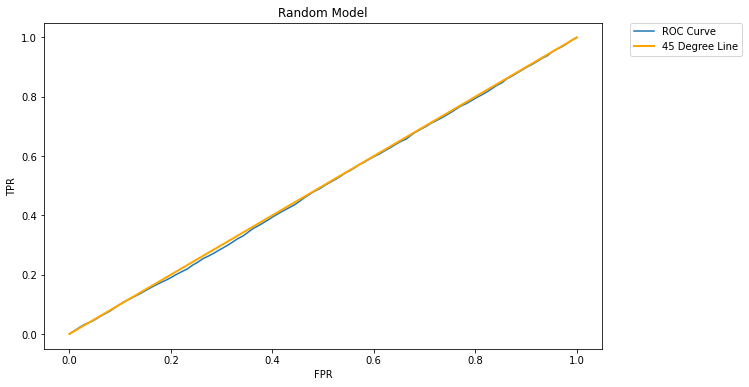

In [83]:
# ROC Curve
plt.figure(figsize=(10,6))
plt.title('Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot( df_thresholds['FPR'], df_thresholds['TPR'], label="ROC Curve")
# Add 45 degree line
plt.plot([0, 1], [0, 1], color = 'orange', linewidth = 2,  label="45 Degree Line")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [84]:
y_rain_random[0:10]

array([7.24381281e-01, 9.42750320e-01, 4.56290509e-04, 3.23580494e-01,
       4.09857285e-01, 8.64331326e-01, 2.71309617e-01, 3.64516747e-01,
       3.89879681e-01, 1.10051548e-01])

In [85]:
y_test[0:10]

86232     0
57576     0
124071    0
117955    0
133468    0
136631    0
75844     1
21853     1
19088     0
132305    0
Name: RainTomorrow, dtype: int8

##### 5.	The third model is going to be an ideal model in which the probabilities of the positive and negative classes are completely separated (for example, all values less than 0.7 are in the negative class and all values above 0.7 are in the positive class). Create this type of numpy array with perfect separation (for this purpose, you can create a new y_test numpy array which has all 0s to one side and all 1s on the other side, and the prediction values between 0 and 1 uniformly distributed with the same distinction). Pass these two numpy arrays into the function.
* Plot TPR/FPR (y-axis) vs. threshold values (x-axis). 
* Plot TPR (y-axis) vs. FPR (x-axis). The second plot is known as the ROC curve.


In [87]:
# Calculate thresholds
y_rain_prediction = log_regression.predict_proba(X_test)[:,1] 
y_new_test = [ 1 if prediction >=0.7 else 0 for prediction in y_rain_prediction  ]

In [88]:
# Print first 10
y_rain_prediction[0:10]

array([0.07600766, 0.12069615, 0.13622584, 0.00779138, 0.03115339,
       0.01685546, 0.78193322, 0.74028291, 0.07330444, 0.11065216])

In [89]:
# Print first 10 labels to confirm logic
y_new_test[0:10]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

In [90]:
df_thresholds = compute_fpr_tpr(y_rain_prediction, y_new_test)

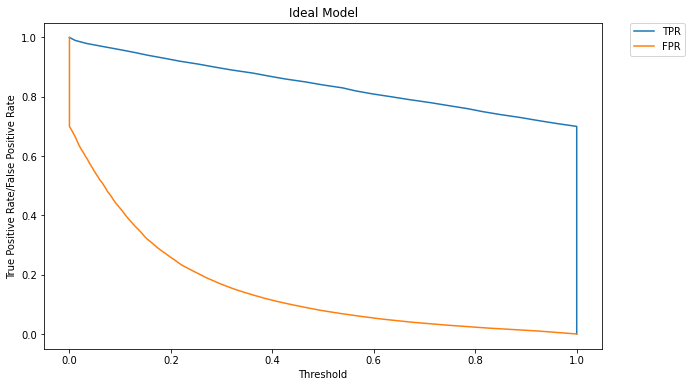

In [91]:
plt.figure(figsize=(10,6))
plt.title('Ideal Model')
plt.xlabel('Threshold')
plt.ylabel('True Positive Rate/False Positive Rate')
plt.plot(df_thresholds['TPR'], df_thresholds['THRESHOLD'], label="TPR")
plt.plot(df_thresholds['FPR'], df_thresholds['THRESHOLD'], label="FPR")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

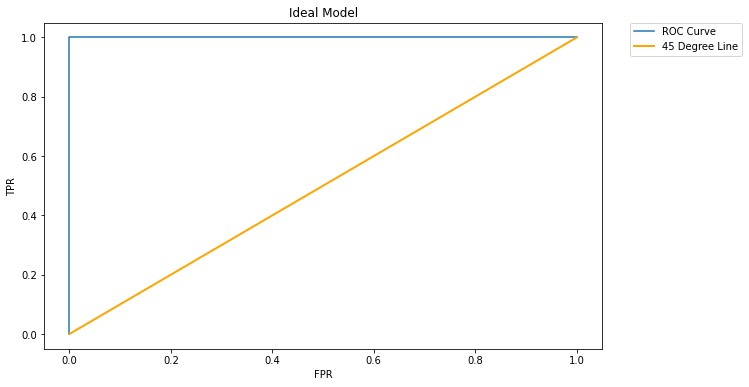

In [92]:
# ROC Curve
plt.figure(figsize=(10,6))
plt.title('Ideal Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot( df_thresholds['FPR'], df_thresholds['TPR'], label="ROC Curve")
# Add 45 degree line
plt.plot([0, 1], [0, 1], color = 'orange', linewidth = 2,  label="45 Degree Line")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

##### 6.	Observe the differences in the shape of the plots for all the three models, with our logistic regression model falling somewhere in between that of an ideal one and a random one.

##### 7.   Obtain the AUC score for our logistic regression model.

In [94]:
y_rain_prediction = log_regression.predict_proba(X_test)[:,1] 
AUC_score = roc_auc_score(y_test, y_rain_prediction)

In [97]:
print(f"AUC score:{AUC_score:.4f}")

AUC score:0.8728


In [104]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_rain_prediction)

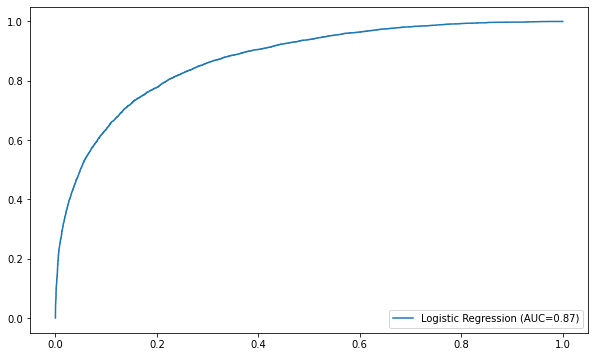

In [111]:
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,label=f"Logistic Regression (AUC={AUC_score:.2f})")
plt.legend(loc=4)
plt.show()